# QR Code 아트 만들기

> 유튜브 [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

- Stable Diffusion Img2Img
- ControlNet
- QR Code Generator

코드없이 만들어보기 https://huggingface.co/spaces/huggingface-projects/QR-code-AI-art-generator

In [ ]:
!pip install -q qrcode diffusers transformers accelerate xformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import qrcode
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler, DPMSolverMultistepScheduler
from diffusers.utils import load_image
import matplotlib.pyplot as plt

## Generate QR Code

https://github.com/lincolnloop/python-qrcode

(969, 969)


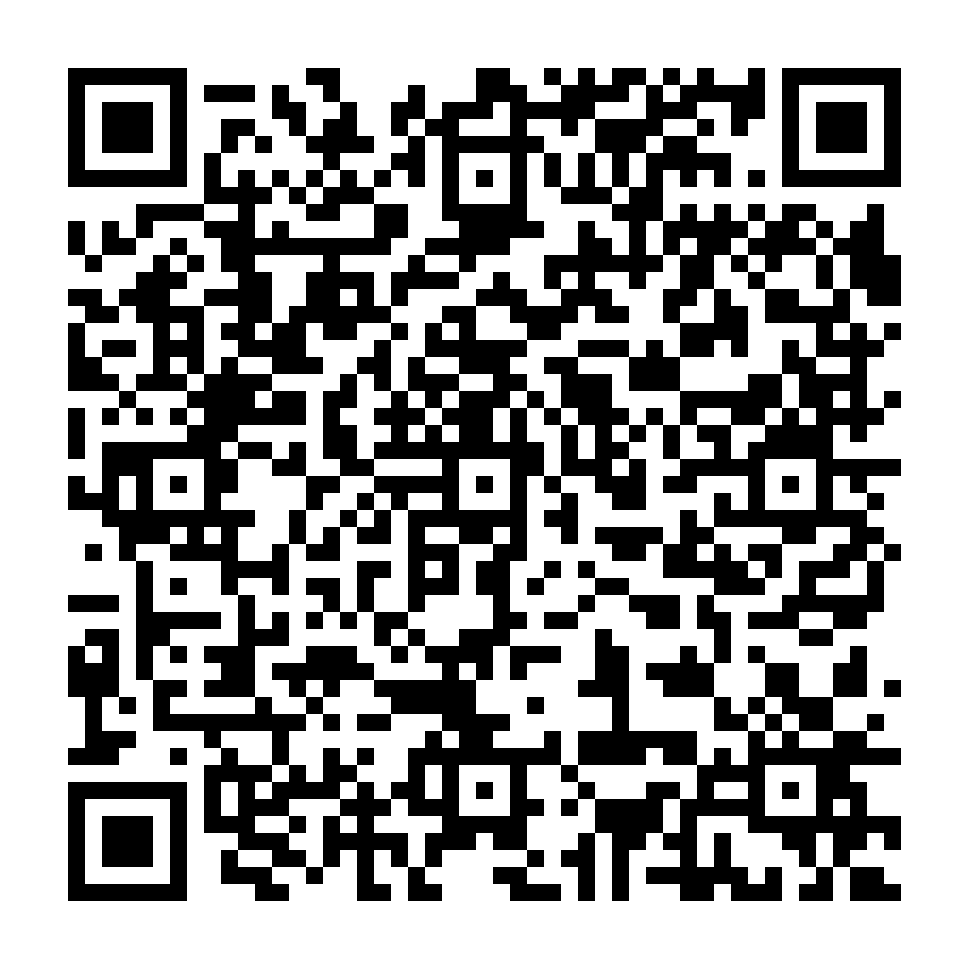

In [ ]:
qr = qrcode.QRCode(
    version=1, # 1-40
    error_correction=qrcode.constants.ERROR_CORRECT_H, # L, M, H
    box_size=17,
    border=4,
)
qr.add_data("https://eunsuok.notion.site/Profile-34a91f735d3a4bc3b388a02a16ffa149?pvs=4")
qr.make()

img = qr.make_image(fill_color="black", back_color="white")

print(img.size)

img

## ControlNet

https://huggingface.co/DionTimmer/controlnet_qrcode-control_v1p_sd15

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v1p_sd15",
    torch_dtype=torch.float16)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras=True, algorithm_type="sde-dpmsolver++")
pipe.enable_model_cpu_offload()

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


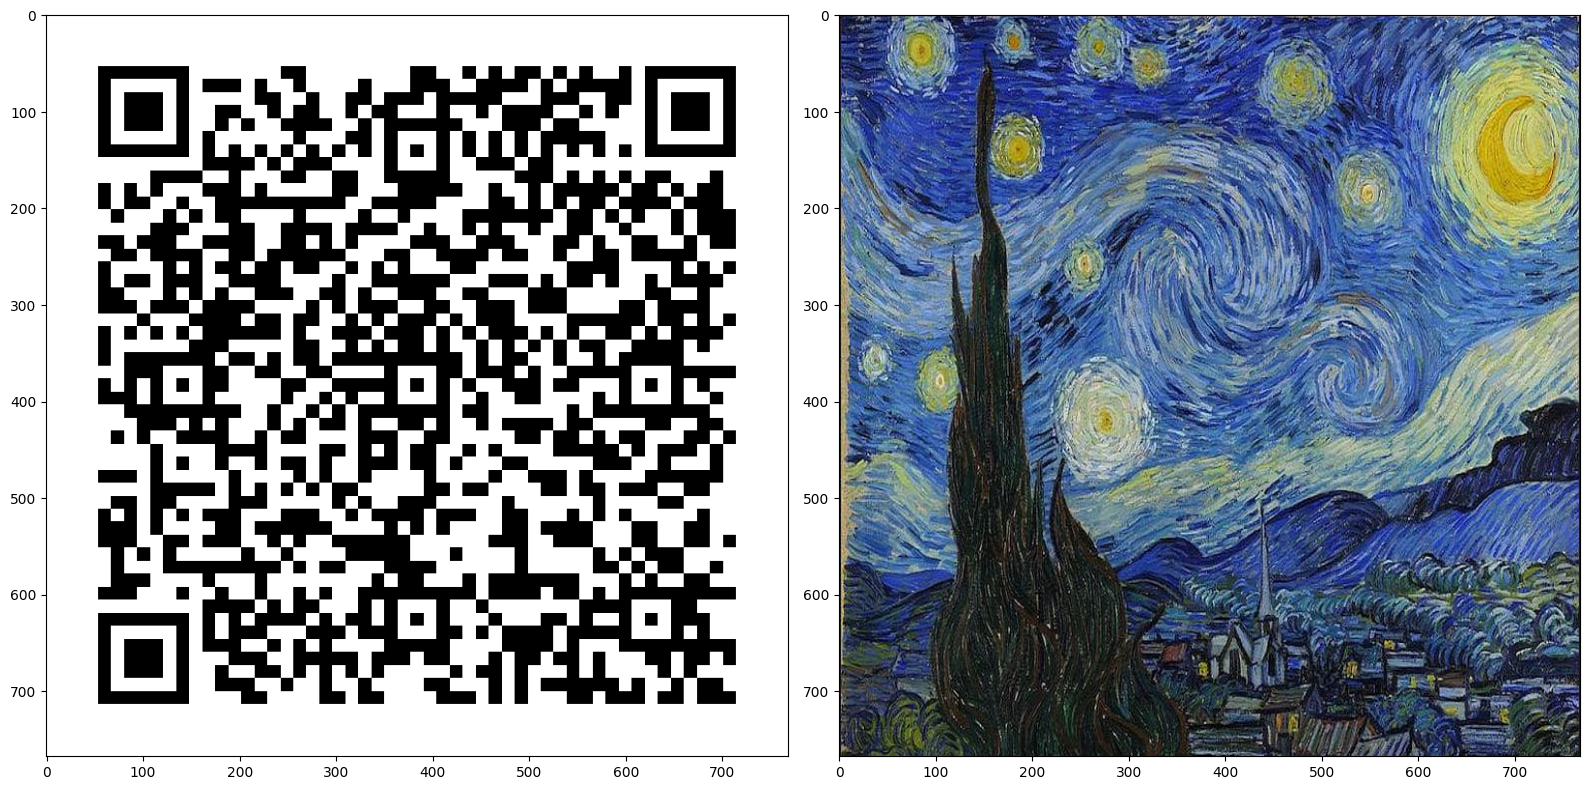

In [ ]:
init_image = load_image("/content/starry night.JPG")

qr_image_resized = img.resize((768, 768))
init_image_resized = init_image.resize((768, 768))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(qr_image_resized)
axes[1].imshow(init_image_resized)
plt.tight_layout()
plt.show()

In [ ]:
print("사진 크기 :",init_image_resized.size)
print("QR코드 크기 : ",qr_image_resized.size)

사진 크기 : (768, 768)
QR코드 크기 :  (768, 768)


## Composite

[StableDiffusionControlNetImg2ImgPipeline 문서](https://huggingface.co/docs/diffusers/api/pipelines/controlnet#diffusers.StableDiffusionControlNetImg2ImgPipeline.__call__)

- image: 배경에 깔릴 이미지
- control_image: QR code
- guidance_scale: Prompt를 얼마나 잘 따라서 만들 것인가
- controlnet_conditioning_scale: QR code를 얼마나 잘 살릴 것인가
- strength: QR code를 얼마나 잘 살릴 것인가
- num_inference_steps: 생성된 이미지 퀄리티, Diffusion denoising steps

  0%|          | 0/148 [00:00<?, ?it/s]

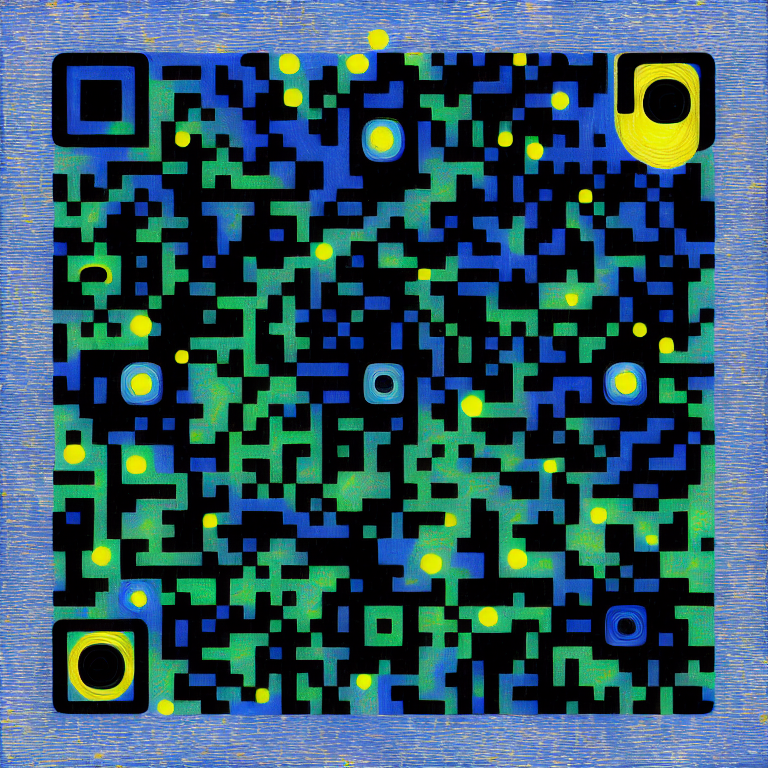

In [ ]:
image = pipe(
    prompt="An image black sky in Gogh style with a qrcode",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=init_image_resized,
    control_image=qr_image_resized,
    width=768,
    height=768,
    guidance_scale=7.5, # 20, 7.5
    controlnet_conditioning_scale=1.7, # 1.5. 1.3
    generator=torch.manual_seed(123121231),
    strength=0.99, # 0.9
    num_inference_steps=150,  # 150, 40
)

image.images[0]